# Galaxy ages from synthethic spectra : Part 1, SSP creation

The project involves generating a simplified version of SSPs, which will represent star clusters. Galaxies will be modeled as a collection of SSPs with a given SFH, meaning a galaxy will consist of different SSPs that were born at different times.

To create the SSPs, we will use spectra of representative stars from the Main Sequence (at least one spectrum for each spectral type OBAFGKM, Luminosity Class V), red giant stars (KM, Luminosity Class III), and the Horizontal Branch (G, Luminosity Class III). We will disregard the effects of metallicity on the spectra.

Stellar spectra is obtained from the ESO Stellar Library database.

Steps to Follow

	1.	Normalize Spectra: Normalize the spectra using the total luminosity of the stars. 
    2.      Star Formation and Evolution: Create a STAR class.
	3.	SFH for Galaxies: Each galaxy begins its existence at a very low redshift with a cloud composed 100% of gas.
	4.	Construct Galaxy Spectrum: Build the spectrum of the galaxy.

## Normalize Spectra

### Dependencies

In [472]:
from astropy.io import fits
from ftplib import FTP
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse

### Code

Here we need tu obtain the spectra provided in the ESO Stellar Library. For this several functions are created.

"download_spectrum_ftp", finds the content of an file by a given url to the file. 
"open_fits_from_data" finds the geader and data from the fits.file downloaded by "download_spectrum_ftp".

Next, the spectrum obtained need to be normalized, then the following functions are made.

"calculate_total_luminosity", calculate the total luminosity of the spectrum. 
"normalize_spectrum_to_luminosity", normalize a stellar spectrum relative to the total luminosity

And in "normalize_spectrum_to_luminosity" the wavelengths and spectrum are truncated between 2450 Å and 10050 Å, as the data outside this range is modeled and not obtained form telescopes.

In [523]:
def download_spectrum_ftp(url):
    '''
        Downloads a file from an FTP server given a URL and returns its content.

    INPUTS:
    url (str): The FTP URL of the file to download. The URL should be in the format:
               'ftp://hostname/path/to/file'.

    OUTPUT:
    data: The content of the downloaded file.
    '''

    parsed_url = urlparse(url)
    ftp_host = parsed_url.hostname
    ftp_file_path = parsed_url.path

    ftp = FTP(ftp_host)
    ftp.login()

    file_data = BytesIO()
    ftp.retrbinary(f"RETR {ftp_file_path}", file_data.write)
    ftp.quit()

    file_data.seek(0)
    return file_data.read()


def open_fits_from_data(data):
    '''
        Opens a FITS file from binary data and extracts its header and data.

    This function takes the FITS file and returns the header and
    data of the primary HDU.

    INPUT:
    data (bytes): Binary data of the FITS file.

    OUTPUT:
    tuple: A tuple containing:
        - header: The header of the primary HDU.
        - data: The data of the primary HDU.
    '''
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data


def calculate_total_luminosity(wavelength, spectrum):
    '''
        Calculates the total luminosity of a spectrum.

    This function uses numerical integration to calculate the total luminosity
    of a spectrum given the wavelength and flux data.

    INPUTS:
    wavelength (array-like): Array of wavelength values.
    spectrum (array-like): Array of flux values corresponding to the wavelengths.

    OUTPUT:
    float: The total luminosity of the spectrum.
    '''
    luminosity = np.trapz(spectrum, x=wavelength)
    return luminosity


def normalize_spectrum_to_luminosity(header, data):
    '''
    Normalizes a stellar spectrum relative to its total luminosity.

    This function takes the header and data of a FITS file, calculates the wavelength range,
    computes the total luminosity of the spectrum, and then normalizes the spectrum by dividing
    it by the total luminosity.

    INPUT:
    header (Header): The header of the primary HDU from a FITS file.
    data (array-like): The data (flux values) of the primary HDU from a FITS file.

    OUTPUT:
    tuple: A tuple containing:
        - wavelength (array-like): The calculated wavelength range.
        - normalized_spectrum (array-like): The normalized spectrum.
        - total_luminosity (float): The total luminosity of the spectrum.
    '''

    crpix1 = header['CRPIX1']  # Reference pixel
    crval1 = header['CRVAL1']  # Value of the reference pixel
    cdelt1 = header['CDELT1']  # Increment per pixel

    # Calculate the wavelength range
    wavelength = crval1 + (np.arange(len(data)) - crpix1 + 1) * cdelt1

    # Calculate the total luminosity of the spectrum
    total_luminosity = calculate_total_luminosity(wavelength, data)

    # Normalize the spectrum by dividing by the total luminosity
    normalized_spectrum = data / total_luminosity

    mask = (wavelength > 2450) & (wavelength < 10050)
    normalized_spectrum = normalized_spectrum[mask]
    wavelength = wavelength[mask]

    return wavelength, normalized_spectrum, total_luminosity, mask

### Visualization

In [503]:
# Intrinsic luminosity dictionary

intrinsic_lum = {
    'O5': 846000, 'O9': 95000,
    'B0': 20000, 'B1': 4600,
    'A0': 22, 'A2': 18,
    'F0': 4.3, 'F2': 3.3,
    'G0': 1.3, 'G2': 1,
    'K0': 0.54, 'K2': 0.38,
    'M0': 0.069, 'M1': 0.064
}

# Spectra URLs dictionary with explicit spectral type
spectra_urls = {
    "O5": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
    "O9": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits",
    "B0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
    "B1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits",
    "A0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
    "A2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits",
    "F0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
    "F2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits",
    "G0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
    "G2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits",
    "K0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
    "K2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits",
    "M0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
    "M1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
}

# Spectra URLs dictionary with explicit spectral type for red giant and horizontal branches
spectra_branch_urls = {
    'G5': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukg5iii.fits',
    'G8': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukg8iii.fits',
    'K0': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk0iii.fits',
    'K1': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk0iii.fits',
    'K2': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukk2iii.fits',
    'M4': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm4iii.fits',
    'M2': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm2iii.fits',
    'M6': 'ftp://ftp.eso.org/web/sci/facilities/paranal/instruments/isaac/tools/lib/ukm6iii.fits'
}

# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}
spectra_branch = {key: download_spectrum_ftp(url) for key, url in spectra_branch_urls.items()}

0.11383453
0.16155486
0.0814439


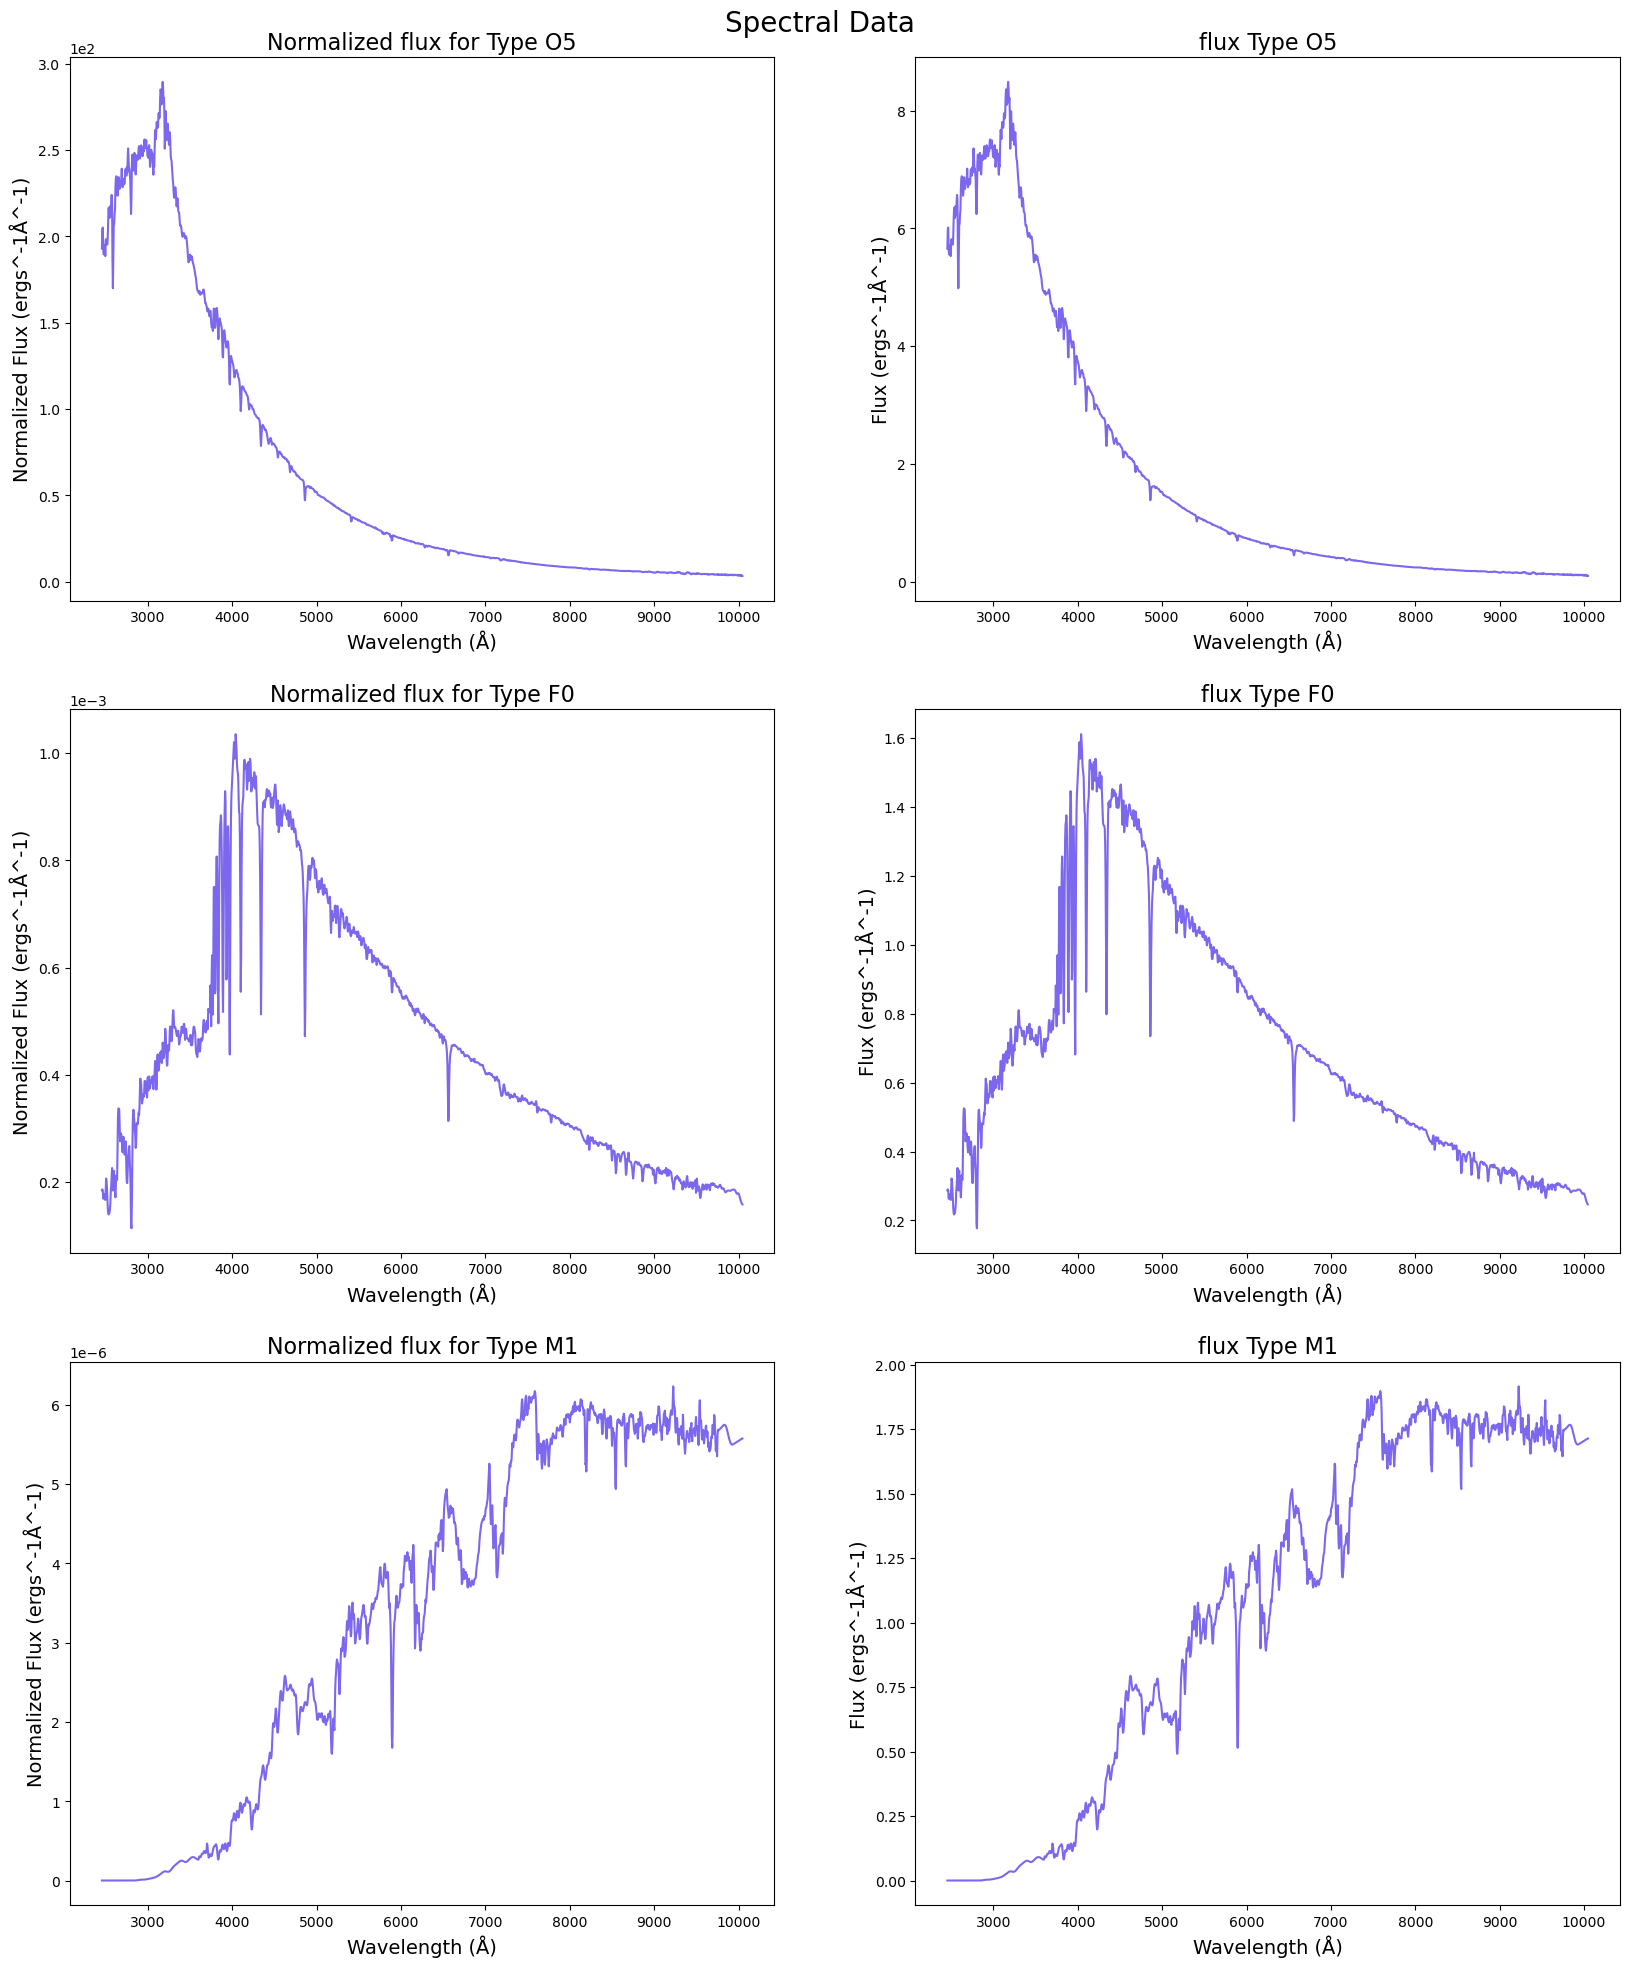

In [533]:
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
examples_types = ('O5', 'F0', 'M1')
axes = axes.flatten()
for spectral_type, i in zip(examples_types, range(0, 6, 2)):
    fits_data = spectra[spectral_type]
    header, data = open_fits_from_data(fits_data)

    # Normalize the spectrum relative to the luminosity
    wavelength, normalized_spectrum, total_luminosity, mask = normalize_spectrum_to_luminosity(header, data)

    # Get the intrinsic luminosity
    intrinsic_luminosity = intrinsic_lum[spectral_type]

    # Multiply the normalized spectrum by the intrinsic luminosity
    intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

    # Plot the spectrum
    axes[i].plot(wavelength,
             intrinsic_normalized_spectrum,
             color='mediumslateblue')
    axes[i].set_xlabel('Wavelength (Å)', fontsize=14)
    axes[i].set_ylabel('Normalized Flux (ergs^-1Å^-1)', fontsize=14)
    axes[i].set_title(f'Normalized flux for Type {spectral_type}', fontsize=16)
    axes[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    data = data[mask]
    axes[i+1].plot(wavelength,
             data,
             color='mediumslateblue')
    axes[i+1].set_xlabel('Wavelength (Å)', fontsize=14)
    axes[i+1].set_ylabel('Flux (ergs^-1Å^-1)', fontsize=14)
    axes[i+1].set_title(f'flux Type {spectral_type}', fontsize=16)
    axes[i+1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.suptitle('Spectral Data', y=0.9, fontsize=20)
plt.savefig('compare_spectra.pdf', format='pdf')
plt.show()

From the plots for three different spectral types is plausible to note that the spectrum are well normalized as the y-axis changes while the behaviour of the plot remain the same.

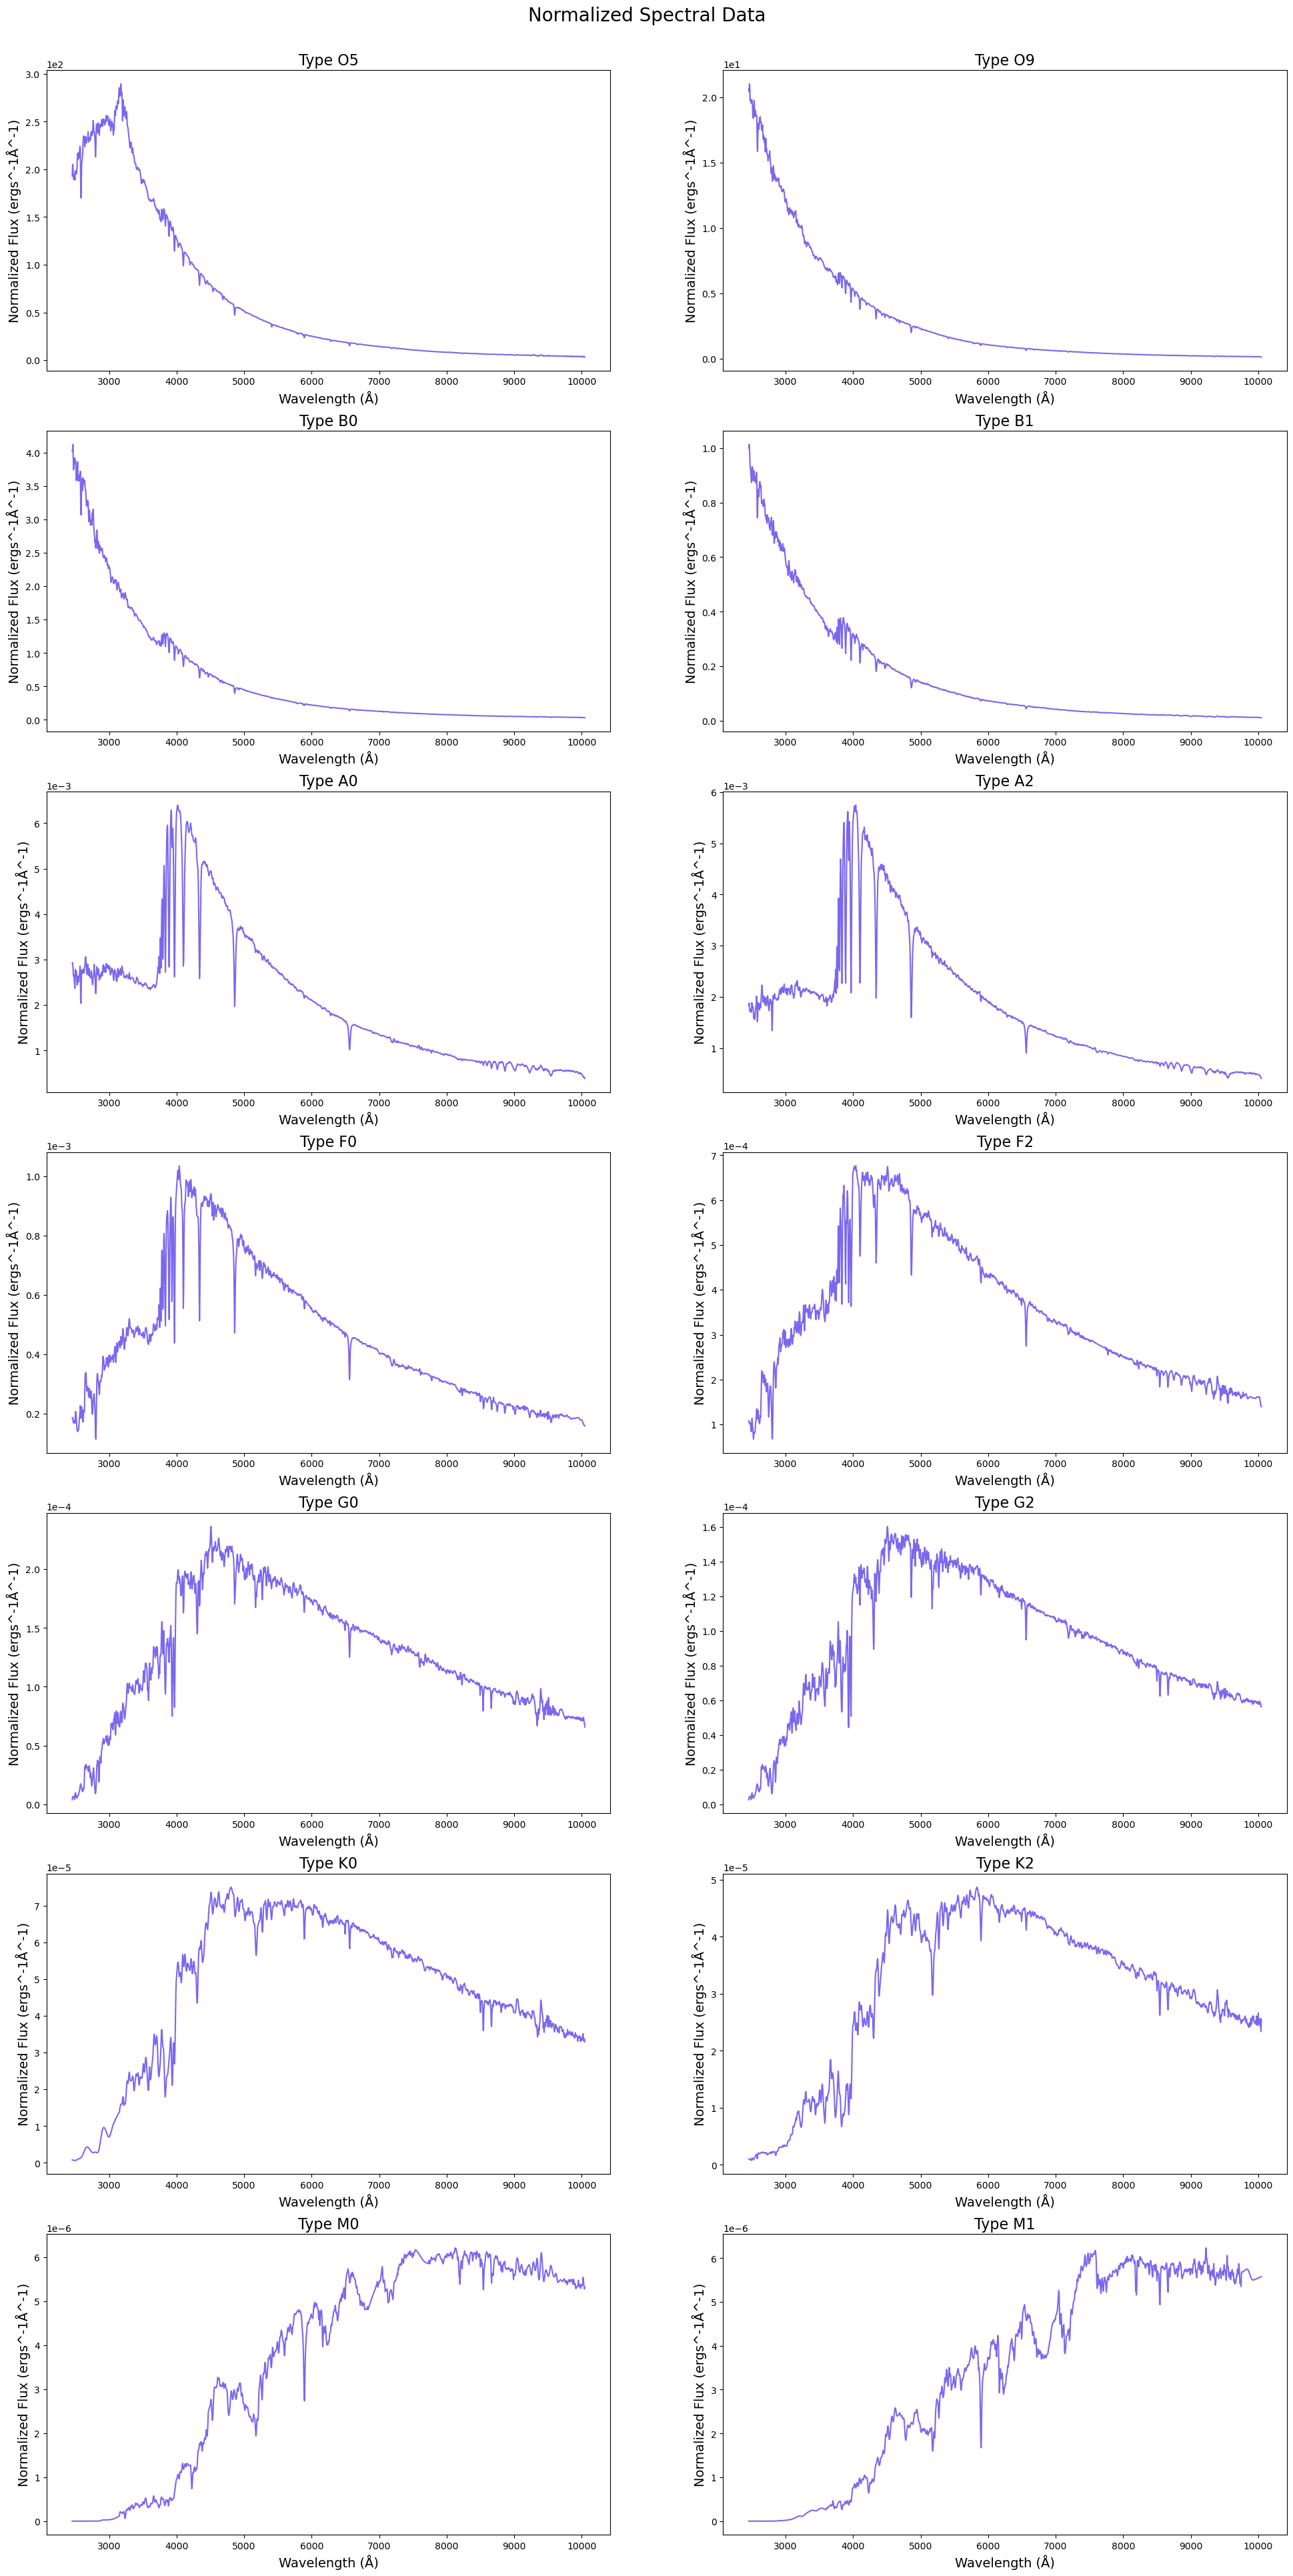

In [526]:
fig, axes = plt.subplots(7, 2, figsize=(24, 48))
axes = axes.flatten()

for (spectral_type, fits_data), ax in zip(spectra.items(), axes):
    # Obtain the header and data from the FITS file
    header, data = open_fits_from_data(fits_data)

    # Normalize the spectrum relative to the luminosity
    wavelength, normalized_spectrum, total_luminosity, _ = normalize_spectrum_to_luminosity(header, data)

    # Get the intrinsic luminosity
    intrinsic_luminosity = intrinsic_lum[spectral_type]

    # Multiply the normalized spectrum by the intrinsic luminosity
    intrinsic_normalized_spectrum = normalized_spectrum * intrinsic_luminosity

    # Plot the spectrum
    ax.plot(wavelength,
             intrinsic_normalized_spectrum,
             color='mediumslateblue')
    ax.set_xlabel('Wavelength (Å)', fontsize=14)
    ax.set_ylabel('Normalized Flux (ergs^-1Å^-1)', fontsize=14)
    ax.set_title(f'Type {spectral_type}', fontsize=16)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.suptitle('Normalized Spectral Data', y=0.9, fontsize=20)
plt.savefig('norm_spectra.pdf', format='pdf')
plt.show()


This plot represent every star spectrum that will be used for the star class and the creation of stars and consequently the galaxy sspectrum 

## Star Class

### Dependencies

In [535]:
from astropy.constants import sigma_sb, L_sun, M_sun, R_sun
from astropy.io import fits
import astropy.units as u
from io import BytesIO
import numpy as np

### Code

In [595]:
class STAR:
    """
    A class to represent a star and simulate its evolution through different stages.
    """
    def __init__(self, mass, born, weight):
        """
        INPUTS:
        mass (float): The mass of the star in solar masses.
        born (float): The birth time of the star in Gyr (gigayears).
        """

        global spectra
        global spectra_branch

        self.spectra = spectra
        self.spectra_branch = spectra_branch

        self.weight = weight
        # Initial mass of the star
        self.mass = mass*M_sun

        # Time in main sequence
        cons = (10 * u.Gyr)
        self.t_ms = cons / (( self.mass/ M_sun)**3)

        # Time on which the star was born
        self.born = born * u.Gyr
        self.stage = self.born

        # Initial branch at born stage
        self.branch = 'MS'

        # Get T, L, spectral type and spectrum
        self.properties()
        self.get_star_spectrum(self.spectra)


    def properties(self):
        """
        Set the T, L and spectral type of the star based on its mass using the mass-luminosity relation
        and the Stefan-Boltzmann law.
        """
        # Using Mass-Luminosity relation
        if self.mass/M_sun < 0.43:
            self.luminosity = 0.23 * ((self.mass/M_sun) ** 2.3) * L_sun
        elif 0.43 <= self.mass/M_sun < 2.0:
            self.luminosity = ((self.mass/M_sun) ** 4.0) * L_sun
        elif 2.0 <= self.mass/M_sun < 55:
            self.luminosity = 1.4 * L_sun * ((self.mass/M_sun) ** 3.5)
        elif 55 <= self.mass/M_sun:
            self.luminosity = 32000 * (self.mass/M_sun) * L_sun

        # Using Stafan-Boltzmann law
        sigma = sigma_sb.to(u.W / (u.m**2 * u.K**4))
        self.radii = R_sun * (self.mass / M_sun)**0.8
        denominator = (4 * np.pi * (self.radii**2) * sigma)
        self.temperature = ((self.luminosity / denominator) ** 0.25)

        # Spectral type classification
        if (self.mass/M_sun) > 16:
            self.spectral_type = 'O'
        elif (self.mass/M_sun) > 2.1:
            self.spectral_type = 'B'
        elif (self.mass/M_sun) > 1.4:
            self.spectral_type = 'A'
        elif (self.mass/M_sun) > 1.04:
            self.spectral_type = 'F'
        elif (self.mass/M_sun) > 0.8:
            self.spectral_type = 'G'
        elif (self.mass/M_sun) > 0.45:
            self.spectral_type = 'K'
        else:
            self.spectral_type = 'M'

    def read_spectrum_from_fits(self, data):
        """
        Read the spectrum from a FITS file.

        INPUT:
        data (bytes): The binary data of the FITS file.

        OUTPUT:
        tuple: A tuple containing the wavelength array and the spectrum data array.
        """
        with fits.open(BytesIO(data)) as hdul:
            header = hdul[0].header
            spectrum_data = hdul[0].data

            wavelengths = np.arange(header['CRVAL1'],
                                    header['CRVAL1'] + header['CDELT1'] * len(spectrum_data),
                                    header['CDELT1'])
            return wavelengths[:len(spectrum_data)], spectrum_data

    def get_star_spectrum(self, spectra_to_use):
        """
        Get the star's spectrum based on its spectral type.

        INPUT:
        spectra_to_use (dict): The dictionary of available spectra.
        """
        new_type = [type for type in list(spectra_to_use) if type.startswith(self.spectral_type)]
        new_spectral_type = np.random.choice(new_type)
        self.spectral_type = new_spectral_type

        if new_spectral_type in spectra_to_use:

            data = spectra_to_use[new_spectral_type]
            self.wavelengths, self.spectrum = self.read_spectrum_from_fits(data)

            self.total_lum = np.trapz(self.spectrum, x=self.wavelengths)

            self.flux = self.spectrum / self.total_lum
            mask = (self.wavelengths < 10050) & (self.wavelengths > 2450)
            self.wavelength = self.wavelengths[mask]
            self.spectrum = self.spectrum[mask]
            self.flux = self.flux[mask]

        else:
            raise ValueError(f"Spectral type {new_spectral_type} not available in spectra.")

    def plot(self):
        """
        Plot the star's normalized spectrum.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.wavelength,
                    self.flux,
                    color='mediumslateblue')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Normalized Flux (ergs^-1Å^-1)') # ergs−1A−1
        plt.title(f'Normalized Spectral Data - Type {self.spectral_type} - branch {self.branch}')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.show()

    def new_properties(self):
        """
        Update the properties of the star for different branches (RG, HB).
        """
        assert self.branch == 'RG' or self.branch == 'HB', f"Branch must be 'RG' or 'HB', but got {self.branch}"
        new_proper = {
            'G5': (5010 * u.K, 127 * L_sun),
            'G8': (4870 * u.K, 113 * L_sun),
            'K0': (4720 * u.K, 96 * L_sun),
            'K1': (4580 * u.K, 82 * L_sun),
            'K2': (4460 * u.K, 70 * L_sun),
            'M2': (3500 * u.K, 11 * L_sun),
            'M4': (3100 * u.K, 7.4 * L_sun),
            'M6': (2800 * u.K, 3.3 * L_sun),
        }
        self.temperature, self.luminosity = new_proper[self.spectral_type]

    def update(self, t):
        """
        Update the star's properties based on its age and evolutionary stage.

        Parameters:
        t (float): The current age of the universe in Gyr (gigayears).
        """
        # T es edad del universo!

        # Star life (T_universe - T_born)
        life = t - self.born

        # Time in horizontal branch
        HB_life = 1 *u.Gyr + 1*u.Myr

        if life.value < 0:
            self.branch = 'Unborn Star'
            self.flux = np.zeros(self.spectrum.shape)

        # Star is just born again
        elif life.value > 0. and self.branch == 'Unborn Star':
            self.branch = 'MS'
            self.properties()
            self.get_star_spectrum(self.spectra)

        elif (self.mass/M_sun) < 5:
            # Outside of main sequence
            if life > self.t_ms:
                # In time of Red giant branch
                if life - self.t_ms < 1 * u.Gyr:
                    # First time at RG branch
                    if self.branch == 'MS' or self.branch == 'Unborn Star':
                        self.branch = 'RG'
                        self.spectral_type = 'K'
                        self.get_star_spectrum(self.spectra_branch)
                        self.new_properties()
                        self.flux = self.spectrum * (self.luminosity/L_sun) * self.weight

                    # Second time ar RG branch
                    elif self.branch == 'RG':
                        self.spectral_type = 'M'
                        self.get_star_spectrum(self.spectra_branch)
                        self.new_properties()
                        self.flux = self.spectrum * (self.luminosity/L_sun) * self.weight

                elif life - self.t_ms < HB_life:
                    self.branch = 'HB'
                    self.spectral_type = 'G'
                    self.get_star_spectrum(self.spectra_branch)
                    self.new_properties()
                    self.flux = self.spectrum * (self.luminosity/L_sun) * self.weight

                else:
                    self.branch = 'Dead'
                    self.spectral_type = 'Dead'
                    self.flux = np.zeros(self.spectrum.shape)
        else:
            if life > self.t_ms:
                self.branch = "Dead"
                self.spectral_type = 'Dead'
                self.flux = np.zeros(self.spectrum.shape)


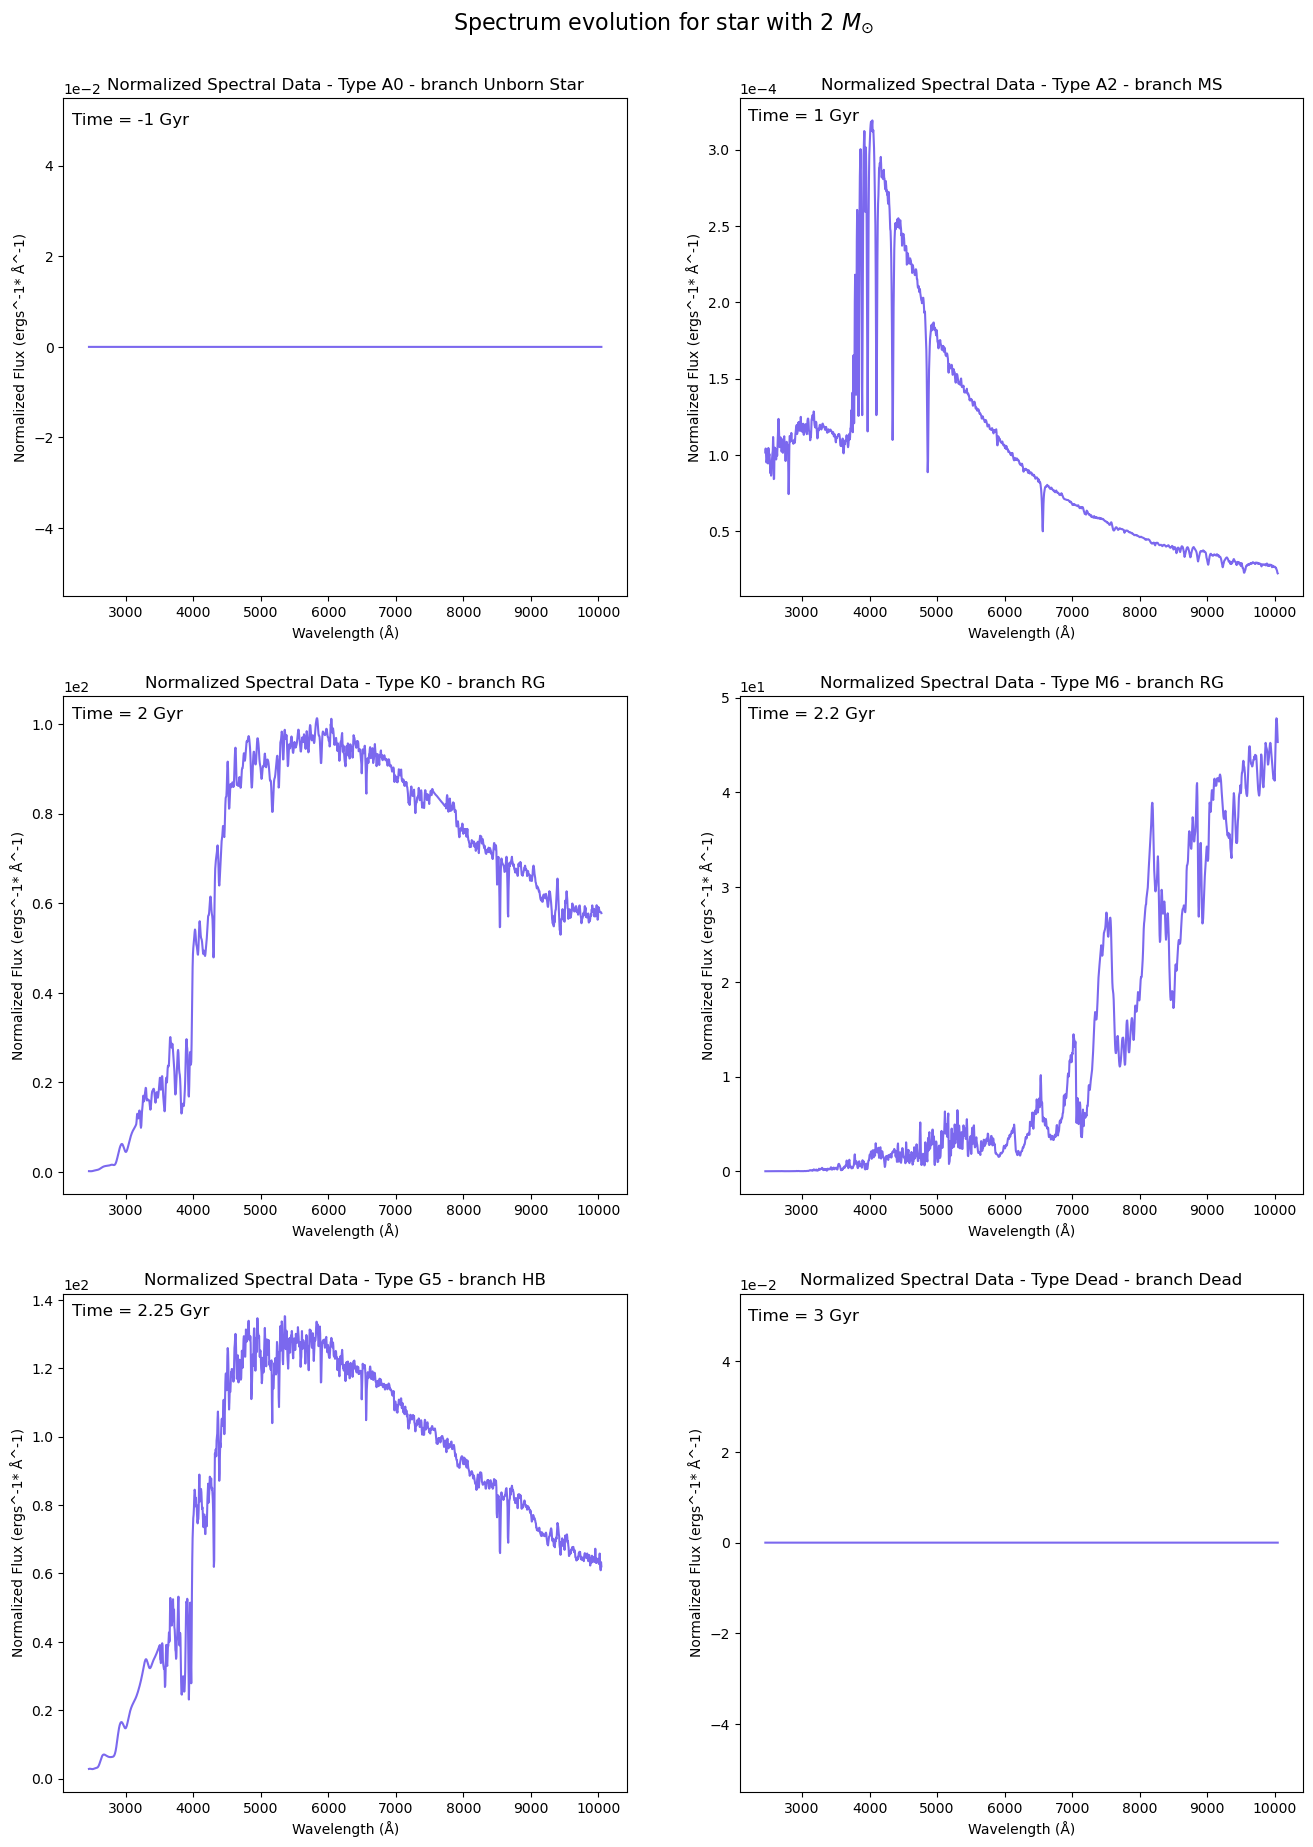

In [603]:
#Plot star evolution

fig , axes = plt.subplots(3, 2, figsize=(16, 22))
axes = axes.flatten()
star = STAR(2, 0, 1)
times = (-1, 1, 2, 2.2, 2.25, 3)
for ax, time in zip(axes, times):
    star.update(time * u.Gyr)
    ax.plot(star.wavelength,
                star.flux,
                color='mediumslateblue')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Normalized Flux (ergs^-1* Å^-1)')
    ax.set_title(f'Normalized Spectral Data - Type {star.spectral_type} - branch {star.branch}')
    if np.max(star.flux) == 0.:
        ax.text(2.2e3, 4.9e-2, f'Time = {time} Gyr', fontsize=12)
    else:
        ax.text(2.2e3, np.max(star.flux), f'Time = {time} Gyr', fontsize=12)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.suptitle('Spectrum evolution for star with 2 ' + r'$M_{\odot}$', y=0.92, size=16)
plt.savefig('spectra_evo.pdf', format='pdf')
plt.show()

With this the STAR class evolve the spectrum within the branches and gives the death of the star with flux 0 

In [596]:
star = STAR(1,0,1)

In [597]:
star.update(-1 *u.Gyr)

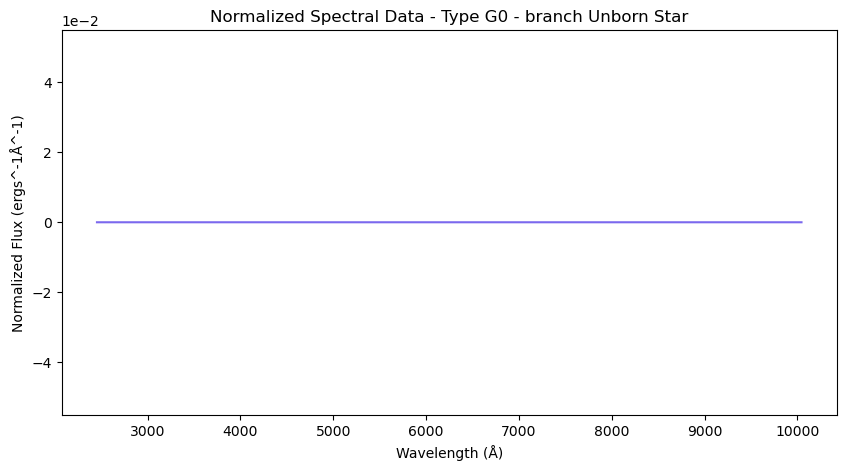

In [598]:
star.plot()

In [599]:
star.update(1*u.Gyr)

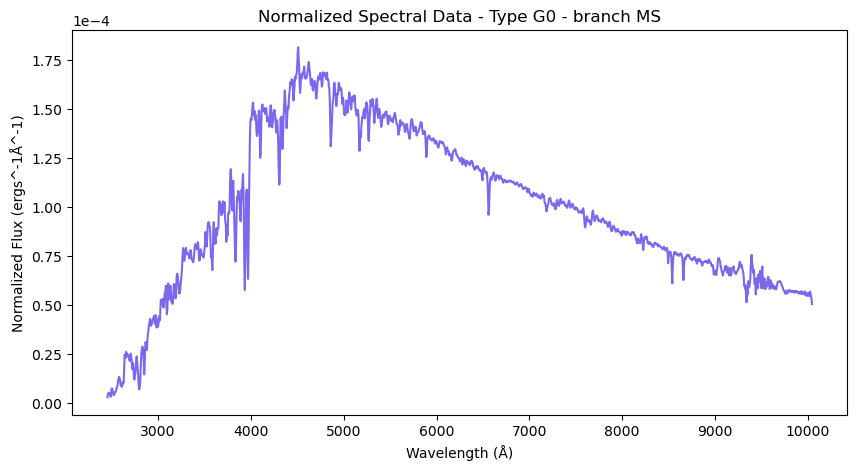

In [600]:
star.plot()